In [70]:
import math
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats.stats import pearsonr
import seaborn as sns
from matplotlib.pyplot import figure

from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

from sklearn.neighbors import KNeighborsClassifier

from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV

import scikitplot as skplt 

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

import warnings
from sklearn.decomposition import PCA

In [2]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
def prepare_dataset(df, class_name):
    df = remove_missing_values(df)
    numeric_columns = get_numeric_columns(df)
    rdf = df.copy(deep=True)
    df, feature_names, class_values = one_hot_encoding(df, class_name)
    real_feature_names = get_real_feature_names(rdf, numeric_columns, class_name)
    rdf = rdf[real_feature_names + (class_values if isinstance(class_name, list) else [class_name])]
    features_map = get_features_map(feature_names, real_feature_names)

    return df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map

def remove_missing_values(df):
    for column_name, nbr_missing in df.isna().sum().to_dict().items():
        if nbr_missing > 0:
            if column_name in df._get_numeric_data().columns:
                mean = df[column_name].mean()
                df[column_name].fillna(mean, inplace=True)
            else:
                mode = df[column_name].mode().values[0]
                df[column_name].fillna(mode, inplace=True)
    return df

def get_numeric_columns(df):
    numeric_columns = list(df._get_numeric_data().columns)
    return numeric_columns

def get_real_feature_names(rdf, numeric_columns, class_name):
    real_feature_names = [c for c in rdf.columns if c in numeric_columns and c != class_name]
    real_feature_names += [c for c in rdf.columns if c not in numeric_columns and c != class_name]
    return real_feature_names

def one_hot_encoding(df, class_name):
    dfX = pd.get_dummies(df[[c for c in df.columns if c != class_name]], prefix_sep='=')
    class_name_map = {v: k for k, v in enumerate(sorted(df[class_name].unique()))}
    dfY = df[class_name].map(class_name_map)
    df = pd.concat([dfX, dfY], axis=1, join_axes=[dfX.index])
    feature_names = list(dfX.columns)
    class_values = sorted(class_name_map)
    return df, feature_names, class_values

def get_features_map(feature_names, real_feature_names):
    features_map = defaultdict(dict)
    i = 0
    j = 0

    while i < len(feature_names) and j < len(real_feature_names):
        if feature_names[i] == real_feature_names[j]:
            features_map[j][feature_names[i]] = j
            i += 1
            j += 1
        elif feature_names[i].startswith(real_feature_names[j]):
            features_map[j][feature_names[i]] = j
            i += 1
        else:
            j += 1
    return features_map

In [4]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [5]:
df = pd.read_csv('trainingDataAfterDataUnderstanding.csv')

In [6]:
class_name = 'Occupancy'
res = prepare_dataset(df, class_name)
df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = res
df.head()

,Temperature,Humidity,Light,CO2,Weekend=no,Weekend=yes,working_hours=no,working_hours=yes,Occupancy
0,23.18,27.2720,426.0,721.25,1,0,0,1,1
1,23.15,27.2675,429.5,714.00,1,0,0,1,1
2,23.15,27.2450,426.0,713.50,1,0,0,1,1
3,23.15,27.2000,426.0,708.25,1,0,0,1,1
4,23.10,27.2000,426.0,704.50,1,0,0,1,1


In [36]:
warnings.filterwarnings("ignore")

In [37]:
attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

In [53]:
param_grid = {'C': np.arange(0.01,100,10)}


lclf = LinearSVC()
grid = GridSearchCV(lclf, param_grid)
grid.fit(X_train,y_train)
report(grid.cv_results_, n_top=3)

Model with rank: 1
Mean validation score: 0.987 (std: 0.003)
Parameters: {'C': 20.01}

Model with rank: 2
Mean validation score: 0.987 (std: 0.003)
Parameters: {'C': 60.01}

Model with rank: 3
Mean validation score: 0.986 (std: 0.003)
Parameters: {'C': 0.01}



In [54]:
lclf=grid.best_estimator_

In [55]:
y_pred = lclf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
cm

Accuracy 0.9901760130986492
F1-score [0.99373041 0.97731569]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1924
           1       0.96      1.00      0.98       519

    accuracy                           0.99      2443
   macro avg       0.98      0.99      0.99      2443
weighted avg       0.99      0.99      0.99      2443



array([[1902,   22],
       [   2,  517]], dtype=int64)

In [56]:
lclf

LinearSVC(C=20.01, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

Changing the C parameter we get similar accuracy value

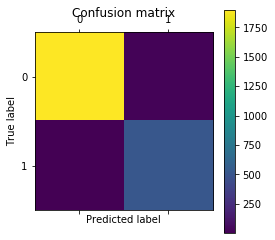

In [57]:
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [58]:
fpr, tpr, _ = roc_curve(y_test, y_pred, pos_label=1)
roc_auc = auc(fpr, tpr)
print(roc_auc)

roc_auc = roc_auc_score(y_test, y_pred, average=None)

0.9923559620091411


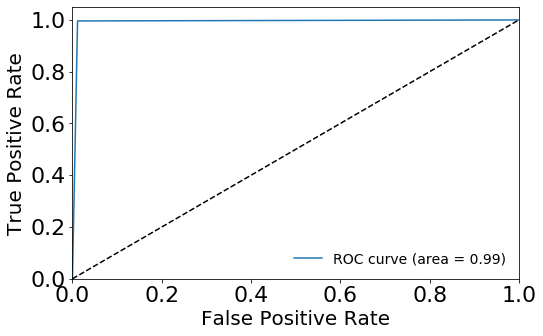

In [59]:
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20) 
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

In [75]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_train)

decision_function = lclf.decision_function(X_train)
support_vector_indices = np.where((2 * y_train - 1) * decision_function <= 1)[0]
support_vectors = X_train[support_vector_indices]

In [76]:
support_vectors_pca = pca.transform(support_vectors)

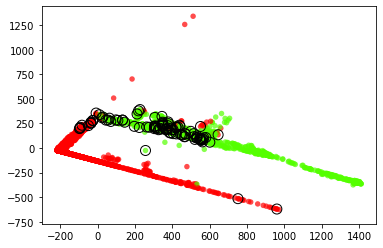

In [77]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap=plt.cm.prism, edgecolor='none', alpha=0.7, s=30)
plt.scatter(support_vectors_pca[:100, 0], support_vectors_pca[:100, 1], s=100,
                linewidth=1, facecolors='none', edgecolors='k')
plt.show()

# Test SVM

In [78]:
test = pd.read_csv('datatestprepared.csv')

In [79]:
class_name = 'Occupancy'
res = prepare_dataset(test, class_name)
test, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = res
test.head()

,Temperature,Humidity,Light,CO2,Weekend=no,Weekend=yes,working_hours=no,working_hours=yes,Occupancy
0,21.7600,31.133333,437.333333,1029.666667,1,0,0,1,1
1,21.7900,31.000000,437.333333,1000.000000,1,0,0,1,1
2,21.7675,31.122500,434.000000,1003.750000,1,0,0,1,1
3,21.7675,31.122500,439.000000,1009.500000,1,0,0,1,1
4,21.7900,31.133333,437.333333,1005.666667,1,0,0,1,1


In [80]:
test_feature = test.drop(['Occupancy'],axis=1)
test_label = test['Occupancy']

In [81]:
preds=lclf.predict(test_feature)

In [82]:
print('Test Accuracy %s' % accuracy_score(test_label, preds))
print('Test F1-score %s' % f1_score(test_label, preds, average=None))
print(classification_report(test_label, preds))
cm=confusion_matrix(test_label, preds)
cm

Test Accuracy 0.9905774341628413
Test F1-score [0.99374566 0.98090419]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      9396
           1       0.97      0.99      0.98      3021

    accuracy                           0.99     12417
   macro avg       0.98      0.99      0.99     12417
weighted avg       0.99      0.99      0.99     12417



array([[9295,  101],
       [  16, 3005]], dtype=int64)

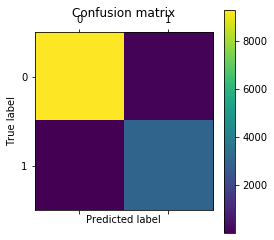

In [83]:
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [84]:
fpr, tpr, _ = roc_curve(test_label, preds)
roc_auc = auc(fpr, tpr)
print(roc_auc)

roc_auc = roc_auc_score(test_label, preds, average=None)
roc_auc

0.9919772427405776


0.9919772427405776

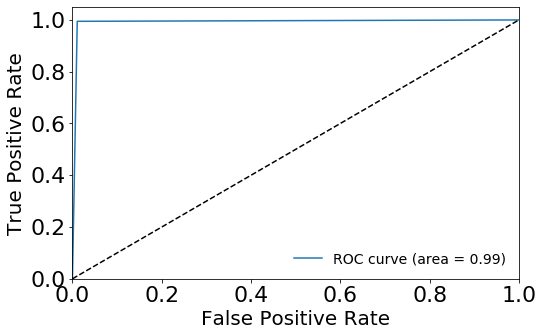

In [85]:
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20) 
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()